# Определение токсичных комментариев для интернет-магазина

# Описание проекта

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
***
**Задача**

Обучить модель классифицировать комментарии на позитивные и негативные.

Заказчик требует, чтобы метрика качества F1 была не меньше 0.75.
***

# 0 Загрузка библиотек и установка глобальных переменных

Загрузка библиотек

In [1]:
!pip install torch -- update
!pip install transformers
!pip install bert
!pip install spacy
!spacy download en_core_web_sm
!pip install pandas -- update
!pip install matplotlib -- update
!pip install stdlib-list

import re
import torch
import spacy
import bert
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import notebook
from lightgbm import LGBMClassifier
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     ---- ----------------------------------- 1.6/12.8 MB 5.6 MB/s eta 0:00:03
     ---------- ----------------------------- 3.4/12.8 MB 7.5 MB/s eta 0:00:02
     ------------------- -------------------- 6.3/12.8 MB 9.4 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 10.0 MB/s eta 0:00:01
     --------------------------------- ----- 11.0/12.8 MB 10.3 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 10.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 9.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


**Установка глобальных переменных**

In [2]:
SAMPLE_SIZE = 2000
BATCH_SIZE = 1
RANDOM_STATE = 42
TEST_SIZE = 0.3
START = datetime.now()

# 1. Подготовка

**Загрузка датасета**

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

**Проверка на соответствие содержимого датасета описанию**

In [4]:
df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0


Содержимое датасета соответствует описанию

**Проверка на наличие пропусков**

In [5]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Пропуски отсутствуют

**Проверка на наличие дубликатов**

In [6]:
print(df.duplicated().sum())

0


Дубликаты отсутствуют

**Оценка распределения комментариев**

<Axes: xlabel='toxic', ylabel='count'>

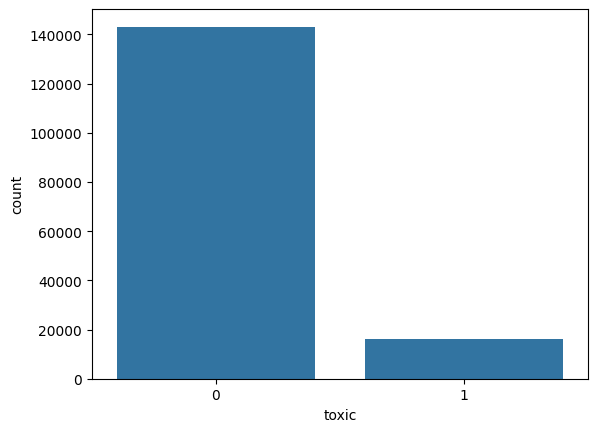

In [7]:
sns.countplot(x=df['toxic']);

Имеется дисбалланс 9:1. Токсичных комментариев значительно меньше, чем нормальных. Необходимо скорректировать веса моделей.

**Настройка модели BERT**

In [8]:
config = transformers.AutoConfig.from_pretrained('unitary/toxic-bert')
config.hidden_dropout_prob = 0.5
config.attention_probs_dropout_prob = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert = transformers.AutoModel.from_pretrained('unitary/toxic-bert', config=config, ignore_mismatched_sizes=True)

tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert', do_lower_case=False)

**Автоматизация. Функция токенизации BERT.**

In [9]:
def tokenizer_bert(df):
    df_tokenized = df.apply(lambda x: tokenizer.encode(x[:500], add_special_tokens=True))
    
    max_len = 0
    for item in df_tokenized.values:
        if len(item) > max_len:
            max_len = len(item)
    
    df_padded = np.array([i + [0]*(max_len-len(i)) for i in df_tokenized.values])
    attention_mask = np.where(df_padded != 0, 1, 0)
    
    embeddings = []
    for i in notebook.tqdm(range(df_padded.shape[0] // BATCH_SIZE)):
        batch = torch.LongTensor(df_padded[BATCH_SIZE*i:BATCH_SIZE*(i+1)], device=device)
        batch_mask = torch.LongTensor(attention_mask[BATCH_SIZE*i:BATCH_SIZE*(i+1)], device=device)
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=batch_mask)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
    return np.concatenate(embeddings)  

**Автоматизация. Лемматизация spacy.**

In [10]:
def lemmatize(text):
    sp = spacy.load("en_core_web_sm")
    lemm_text = " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())
    lemm_text = "".join(lemm_text)
    lemm_text = sp(lemm_text).text
    return lemm_text

**Извлечение тестовой выборки**

In [11]:
df = df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE)

**Лемматизация текста**

In [12]:
%%time
df['lemm_text'] = df['text'].apply(lambda x: lemmatize(x))

CPU times: total: 15min 23s
Wall time: 15min 28s


**Разделение на выборки**

In [13]:
train, test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

**Векторизация**

In [14]:
%%time
X_train_spacy = pd.DataFrame(train['lemm_text'])
X_test_spacy = pd.DataFrame(test['lemm_text'])

X_train_bert = tokenizer_bert(train['text'])
X_test_bert = tokenizer_bert(test['text'])
y_train = train['toxic']
y_test = test['toxic']

  0%|          | 0/1400 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

CPU times: total: 55min 4s
Wall time: 9min 20s


***
**Вывод**
- Выполнено исследование на наличие аномалий;
- Выполнена токенизация и векторизация методом BERT;
- Выполнена лемматизация и векторизация методом spacy.
***

# 2. Обучение

In [15]:
preprocessor_spacy = ColumnTransformer(transformers=[
    ('vectorizer', CountVectorizer(), 'lemm_text'),
], remainder='drop')

**Итоговые пайплайны**

In [16]:
pipe_bert = Pipeline([
    ('models', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
])

pipe_spacy = Pipeline([
    ('preprocessing', preprocessor_spacy),
    ('models', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
])

**Параметры сетки поиска**

In [17]:
param_grid_bert = [
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [20, 40, 60, 80, 100, 120],
        'models__max_depth': range(1, 25, 5),
        'models__boosting_type': ['gbdt', 'dart', 'rf'],
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(10, 20, 2),
        'models__min_samples_leaf': range(2, 4),
        'models__min_samples_split': range(2, 5),
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
    }
]

param_grid_spacy = [
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__n_estimators': [80, 100, 120],
        'models__max_depth': range(1, 25, 5),
        'models__boosting_type': ['gbdt', 'dart', 'rf'],
        'preprocessing__vectorizer__ngram_range': [(1, 5)],
        'preprocessing__vectorizer__strip_accents': ['ascii', 'unicode', 'None'],
        'preprocessing__vectorizer__analyzer': ['word', 'char', 'char_wb']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(10, 20, 2),
        'models__min_samples_leaf': range(2, 4),
        'models__min_samples_split': range(2, 5),
        'preprocessing__vectorizer__ngram_range': [(1, 5)],
        'preprocessing__vectorizer__strip_accents': ['ascii', 'unicode', 'None'],
        'preprocessing__vectorizer__analyzer': ['word', 'char', 'char_wb']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'preprocessing__vectorizer__ngram_range': [(1, 5)],
        'preprocessing__vectorizer__strip_accents': ['ascii', 'unicode', 'None'],
        'preprocessing__vectorizer__analyzer': ['word', 'char', 'char_wb']
    }
]

**Создание экземпляров сеток поиска гиперпараметров**

In [18]:
grid_bert = GridSearchCV(
    pipe_bert,
    param_grid=param_grid_bert,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_spacy = GridSearchCV(
    pipe_spacy,
    param_grid=param_grid_spacy,
    cv=3,
    scoring='f1',
    n_jobs=-1
)

**Обучение моделей и поиск гиперпараметров**

In [19]:
%%time
grid_bert.fit(X_train_bert, y_train)

C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 363.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Us

[LightGBM] [Info] Number of positive: 159, number of negative: 1241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('models',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMClassifier(class_weight='balanced',
                                                    random_state=42)],
                          'models__boosting_type': ['gbdt', 'dart', 'rf'],
                          'models__max_depth': range(1, 25, 5),
                          'models__n_estimators': [20, 40, 60, 80, 100, 120]},
                         {'models': [DecisionTreeClassifier(class_weight='balanced',
                                                            random_state=42)],
                          'models__max_depth': range(10, 20, 2),
                          'models__min_samples_leaf': range(2, 4),
                          'models__min_samples_split': range(2, 5)},
                         {'models': [LogisticRegression(class_weight='balanced',
                                                        random_state=42)]}],
             scoring='f1')

In [20]:
print(f'Лучшая модель для BERT: {grid_bert.best_estimator_['models']}\n\
Метрика f1 на тренировочной выборке для BERT: {grid_bert.best_score_}')

Лучшая модель для BERT: LGBMClassifier(class_weight='balanced', max_depth=11, n_estimators=80,
               random_state=42)
Метрика f1 на тренировочной выборке для BERT: 0.854253647586981


In [21]:
%%time
grid_spacy.fit(X_train_spacy, y_train)

C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1494 fits failed out of a total of 2052.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C

CPU times: total: 57.6 s
Wall time: 5min 37s


C:\Users\Xellos-san\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('vectorizer',
                                                                         CountVectorizer(),
                                                                         'lemm_text')])),
                                       ('models',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [LGBMClassifier(class_weight='balanced',
                                                    random_state=42)],
                          'models__boosting_type': ['gbdt', 'dart', 'rf'],
                          '...
                          'preprocessing__vectorizer__ngram_range': [(1, 5)],
                          'preprocessing__vectorizer__strip_accents': ['ascii',
                                                                       'unicode',
                                                                       'None']},
                         {'models': [LogisticRegression(class_weight='balanced',
                                                        random_state=42)],
                          'preprocessing__vectorizer__analyzer': ['word',
                                                                  'char',
                                                                  'char_wb'],
                          'preprocessing__vectorizer__ngram_range': [(1, 5)],
                          'preprocessing__vectorizer__strip_accents': ['ascii',
                                                                       'unicode',
                                                                       'None']}],
             scoring='f1')

In [22]:
print(f'Лучшая модель для spacy: {grid_spacy.best_estimator_['models']}\n\
Метрика f1 на тренировочной выборке для spacy: {grid_spacy.best_score_}')

Лучшая модель для spacy: LogisticRegression(class_weight='balanced', random_state=42)
Метрика f1 на тренировочной выборке для spacy: 0.5360807581588306


**Получение значений заданной метрики на тестовой выборке для лучших моделей.**

In [23]:
print(f'Метрика f1 на тестовой выборке для BERT: {f1_score(grid_bert.predict(X_test_bert), y_test)}\n\
Метрика f1 на тестовой выборке для spacy: {f1_score(grid_spacy.predict(X_test_spacy), y_test)}')

Метрика f1 на тестовой выборке для BERT: 0.8275862068965517
Метрика f1 на тестовой выборке для spacy: 0.5567010309278351


**График наиболее весомых слов для определения токсичности**

In [24]:
weights = grid_spacy.best_estimator_.named_steps['models'].coef_[0]
words = grid_spacy.best_estimator_.named_steps['preprocessing']['vectorizer'].get_feature_names_out()
words_weights = pd.DataFrame(index=words, data=weights).sort_values(by=0, ascending=False)[:50].T

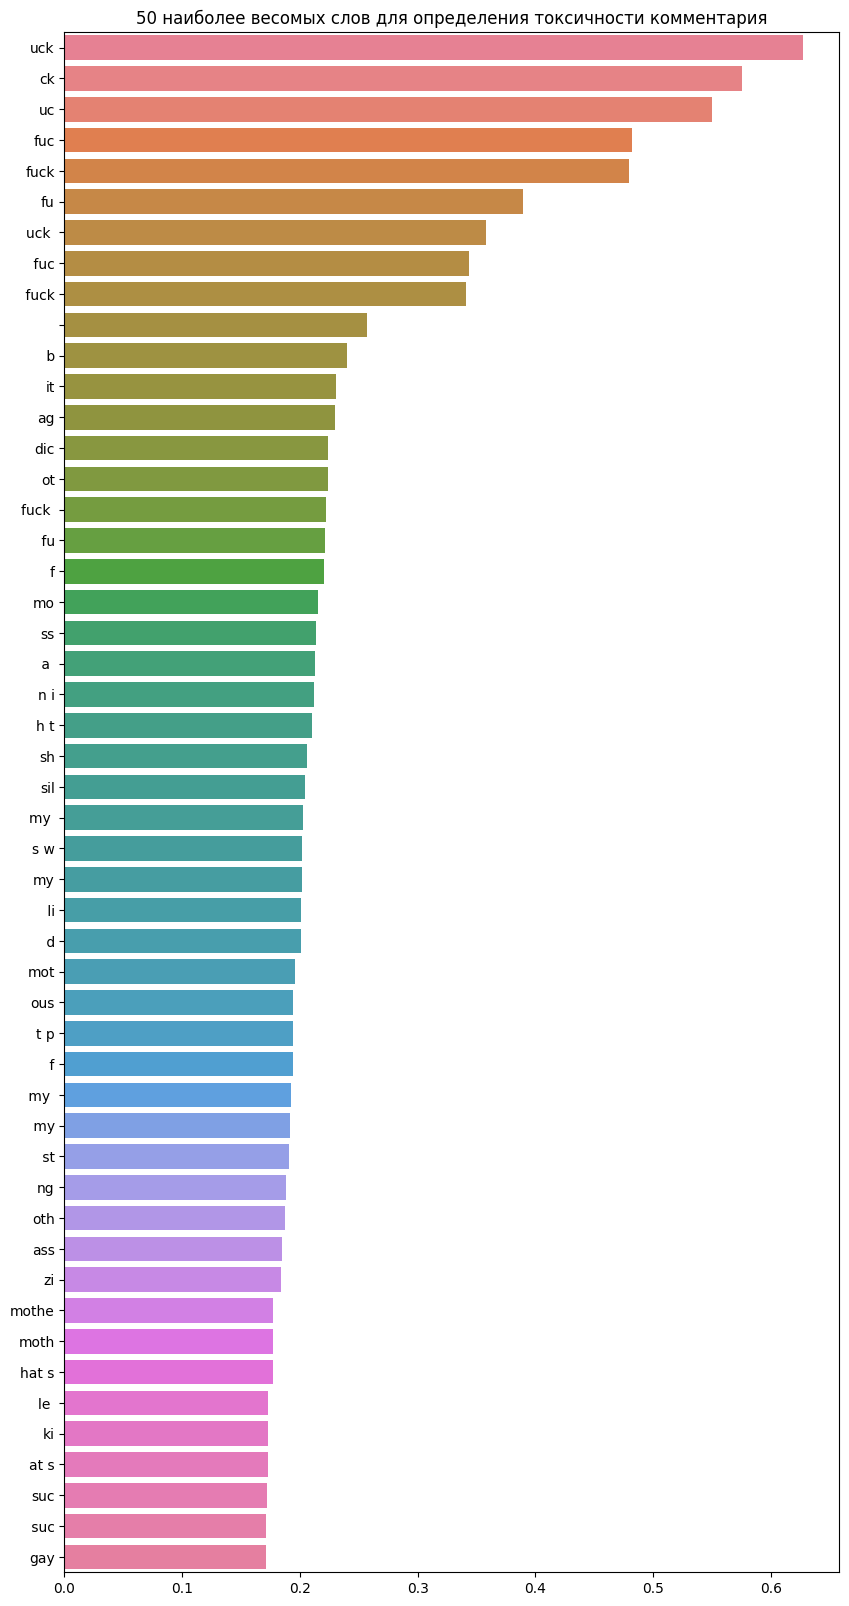

In [25]:
plt.figure(figsize=(10, 20))
sns.barplot(words_weights, orient='h').set_title('50 наиболее весомых слов для определения токсичности комментария');

In [26]:
END = datetime.now()
q = END - START
q.seconds/60

34.016666666666666

# 3. Вывод

- Выполнено исследование на наличие аномалий;
- Выполнена токенизация и векторизация методом BERT;
- Выполнена лемматизация и векторизация методом spacy;
- Создан пайплайн для поиска наилучшей модели;
- Выполнен поиск лучших гиперпараметров для двух датасетов:
    - подготовленным BERT;
    - подготовленным spacy;
- Результаты моделей и метрики f1 для тестовых выборок:
    - BERT:
        - метрика = 0.8276. Соответствует требованию заказчика;
        - модель = LGBMClassifier;
    - spacy:
        - метрика = 0.5567. Не соответствует требованию заказчика;
        - модель = LogisticRegression;
- Лучше всего с прогнозом спарвилась модель LGBMClassifier с векторизатором BERT;
- Приведены 50 наиболее важных слов для классификации комментария как токсичного.